In [2]:
import pandas as pd

In [3]:
# dataset.save_to_disk("multinerd_en")
from datasets import load_from_disk
dataset = load_from_disk("/Users/zoherorabe/Desktop/Excersices/RISE Research/multinerd_en")

/Users/zoherorabe/Desktop/Excersices/RISE Research/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 262560
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 32820
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 32908
    })
})

In [18]:
import pandas as pd
import datasets 
import numpy as np 
from transformers import BertTokenizerFast 
from transformers import DataCollatorForTokenClassification 
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer 

metric = datasets.load_metric("seqeval")
def tokenize_and_align_labels(examples,tokenizer, label_all_tokens=True): 
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True) 
    labels = [] 
    for i, label in enumerate(examples["ner_tags"]): 
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        # word_ids() => Return a list mapping the tokens
        # to their actual word in the initial sentence.
        # It Returns a list indicating the word corresponding to each token. 
        previous_word_idx = None 
        label_ids = []
        # Special tokens like `` and `<\s>` are originally mapped to None 
        # We need to set the label to -100 so they are automatically ignored in the loss function.
        for word_idx in word_ids: 
            if word_idx is None: 
                # set –100 as the label for these special tokens
                label_ids.append(-100)
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            elif word_idx != previous_word_idx:
                # if current word_idx is != prev then its the most regular case
                # and add the corresponding token                 
                label_ids.append(label[word_idx]) 
            else: 
                # to take care of sub-words which have the same word_idx
                # set -100 as well for them, but only if label_all_tokens == False
                label_ids.append(label[word_idx] if label_all_tokens else -100) 
                # mask the subword representations after the first subword
                 
            previous_word_idx = word_idx 
        labels.append(label_ids) 
    tokenized_inputs["labels"] = labels 
    
    return tokenized_inputs


def compute_metrics(eval_preds, label_list):

    pred_logits, labels = eval_preds 
    
    pred_logits = np.argmax(pred_logits, axis=2) 
    # the logits and the probabilities are in the same order,
    # so we don’t need to apply the softmax
    
    # We remove all the values where the label is -100
    predictions = [ 
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100] 
        for prediction, label in zip(pred_logits, labels) 
    ] 
    
    true_labels = [ 
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100] 
       for prediction, label in zip(pred_logits, labels) 
   ] 
    results = metric.compute(predictions=predictions, references=true_labels)

    return { 
          "precision": results["overall_precision"], 
          "recall": results["overall_recall"], 
          "f1": results["overall_f1"], 
          "accuracy": results["overall_accuracy"], 
  }
def fine_tuning_model(dataset, tokenizer_type= "distilbert-base-cased",label_list=[], model_type="distilbert-base-cased",system_type='A'):

    tokenizer = BertTokenizerFast.from_pretrained(tokenizer_type) 

    tokenized_datasets = dataset.map(lambda example: tokenize_and_align_labels(example, tokenizer), batched=True)
    model = AutoModelForTokenClassification.from_pretrained(model_type, num_labels=len(label_list))

    args = TrainingArguments( 
        f"models/{system_type}/{model_type}_checkpoints",
        evaluation_strategy = "epoch", 
        learning_rate=2e-5, 
        per_device_train_batch_size=8, 
        per_device_eval_batch_size=8, 
        num_train_epochs=2, 
        weight_decay=0.01, 
        ) 

    data_collator = DataCollatorForTokenClassification(tokenizer)
    
    trainer = Trainer( 
        model, 
        args, 
        train_dataset=tokenized_datasets['train'], 
        eval_dataset=tokenized_datasets['validation'], 
        data_collator=data_collator, 
        tokenizer=tokenizer, 
        compute_metrics= lambda eval_preds: compute_metrics(eval_preds, label_list),
        ) 
    print('Training the model')
    trainer.train() 
    print('Evaluating the model')
    results = trainer.predict(tokenized_datasets['test'])
    print("Evaluation results:", results.metrics)

    print('Saving the model')
    model.save_pretrained('models/' +system_type+'/'+ model_type + "_ner_model")
    print('Saving the tokenizer')
    tokenizer.save_pretrained('models/'+system_type+'/'+ model_type + "_ner_tokenizer")

    return model, tokenizer, trainer, results, tokenized_datasets
    

In [19]:
system_a_label2id = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30,
  }

system_a_id2label = {id: label for label, id in system_a_label2id.items()}
system_b_id2label = {id: label for label, id in system_a_label2id.items() if id <=8}
system_b_label2id = {label: id for label, id in system_a_label2id.items() if id <=8}

In [20]:
# replace 
def convert_tags(tags):
    for i in range(len(tags)):
        if tags[i] >8:
            tags[i] = 0
    return tags

# Apply the convert_tags function to the 'ner_tags' column in your dataset
dataset_b = dataset.map(lambda example: {'ner_tags': convert_tags(example['ner_tags'])})

In [21]:
#model, tokenizer, trainer, results, tokenized_datasets = fine_tuning_model(dataset, tokenizer_type= "distilbert-base-cased",label2id=label2id, model_type="distilbert-base-cased",system_type= 'A')

In [42]:
# Access training logs
train_logs = trainer_b.state.log_history
valid_logs = trainer_b.state.log_history
train_losses = [log["loss"] for log in train_logs if "loss" in log]
valid_losses = [log["eval_loss"] for log in valid_logs if "eval_loss" in log]


In [43]:
train_logs

[{'loss': 0.0919,
  'learning_rate': 1.9847653869591713e-05,
  'epoch': 0.02,
  'step': 500},
 {'loss': 0.0298,
  'learning_rate': 1.9695307739183427e-05,
  'epoch': 0.03,
  'step': 1000},
 {'loss': 0.0244,
  'learning_rate': 1.9542961608775138e-05,
  'epoch': 0.05,
  'step': 1500},
 {'loss': 0.0219,
  'learning_rate': 1.9390615478366852e-05,
  'epoch': 0.06,
  'step': 2000},
 {'loss': 0.0178,
  'learning_rate': 1.9238269347958563e-05,
  'epoch': 0.08,
  'step': 2500},
 {'loss': 0.0185,
  'learning_rate': 1.9085923217550274e-05,
  'epoch': 0.09,
  'step': 3000},
 {'loss': 0.0166,
  'learning_rate': 1.893357708714199e-05,
  'epoch': 0.11,
  'step': 3500},
 {'loss': 0.0198,
  'learning_rate': 1.87812309567337e-05,
  'epoch': 0.12,
  'step': 4000},
 {'loss': 0.017,
  'learning_rate': 1.8628884826325414e-05,
  'epoch': 0.14,
  'step': 4500},
 {'loss': 0.0164,
  'learning_rate': 1.8476538695917125e-05,
  'epoch': 0.15,
  'step': 5000},
 {'loss': 0.0172,
  'learning_rate': 1.832419256550884e

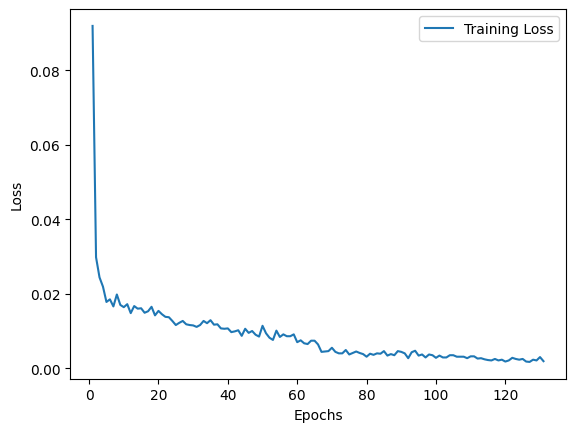

In [45]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss')
#plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
model_b, tokenizer_b, trainer_b, results_b, tokenized_datasets_b = fine_tuning_model(dataset_b, tokenizer_type= "distilbert-base-cased",label_list=list(system_b_label2id.keys()), model_type="distilbert-base-cased",system_type= 'B')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training the model


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                                    
  0%|          | 59/32820 [02:12<2:14:23,  4.06it/s] 

{'loss': 0.0919, 'learning_rate': 1.9847653869591713e-05, 'epoch': 0.02}


                                                    
  0%|          | 59/32820 [03:27<2:14:23,  4.06it/s]  

{'loss': 0.0298, 'learning_rate': 1.9695307739183427e-05, 'epoch': 0.03}


                                                    
  0%|          | 59/32820 [04:40<2:14:23,  4.06it/s]  

{'loss': 0.0244, 'learning_rate': 1.9542961608775138e-05, 'epoch': 0.05}


                                                    
  0%|          | 59/32820 [06:05<2:14:23,  4.06it/s]  

{'loss': 0.0219, 'learning_rate': 1.9390615478366852e-05, 'epoch': 0.06}


                                                    
  0%|          | 59/32820 [07:33<2:14:23,  4.06it/s]  

{'loss': 0.0178, 'learning_rate': 1.9238269347958563e-05, 'epoch': 0.08}


                                                    
  0%|          | 59/32820 [09:07<2:14:23,  4.06it/s]  

{'loss': 0.0185, 'learning_rate': 1.9085923217550274e-05, 'epoch': 0.09}


                                                    
  0%|          | 59/32820 [10:39<2:14:23,  4.06it/s]  

{'loss': 0.0166, 'learning_rate': 1.893357708714199e-05, 'epoch': 0.11}


                                                    
  0%|          | 59/32820 [12:10<2:14:23,  4.06it/s]  

{'loss': 0.0198, 'learning_rate': 1.87812309567337e-05, 'epoch': 0.12}


                                                    
  0%|          | 59/32820 [13:41<2:14:23,  4.06it/s]  

{'loss': 0.017, 'learning_rate': 1.8628884826325414e-05, 'epoch': 0.14}


                                                    
  0%|          | 59/32820 [15:11<2:14:23,  4.06it/s]  

{'loss': 0.0164, 'learning_rate': 1.8476538695917125e-05, 'epoch': 0.15}


                                                    
  0%|          | 59/32820 [16:42<2:14:23,  4.06it/s]  

{'loss': 0.0172, 'learning_rate': 1.832419256550884e-05, 'epoch': 0.17}


                                                    
  0%|          | 59/32820 [18:10<2:14:23,  4.06it/s]  

{'loss': 0.0148, 'learning_rate': 1.817184643510055e-05, 'epoch': 0.18}


                                                    
  0%|          | 59/32820 [19:39<2:14:23,  4.06it/s]  

{'loss': 0.0167, 'learning_rate': 1.801950030469226e-05, 'epoch': 0.2}


                                                    
  0%|          | 59/32820 [21:09<2:14:23,  4.06it/s]  

{'loss': 0.016, 'learning_rate': 1.7867154174283973e-05, 'epoch': 0.21}


                                                    
  0%|          | 59/32820 [22:38<2:14:23,  4.06it/s]  

{'loss': 0.0161, 'learning_rate': 1.7714808043875687e-05, 'epoch': 0.23}


                                                    
  0%|          | 59/32820 [24:08<2:14:23,  4.06it/s]  

{'loss': 0.0149, 'learning_rate': 1.7562461913467398e-05, 'epoch': 0.24}


                                                    
  0%|          | 59/32820 [25:36<2:14:23,  4.06it/s]  

{'loss': 0.0153, 'learning_rate': 1.7410115783059112e-05, 'epoch': 0.26}


                                                    
  0%|          | 59/32820 [27:04<2:14:23,  4.06it/s]  

{'loss': 0.0165, 'learning_rate': 1.7257769652650823e-05, 'epoch': 0.27}


                                                    
  0%|          | 59/32820 [28:33<2:14:23,  4.06it/s]  

{'loss': 0.0142, 'learning_rate': 1.7105423522242538e-05, 'epoch': 0.29}


                                                    
  0%|          | 59/32820 [30:05<2:14:23,  4.06it/s]   

{'loss': 0.0154, 'learning_rate': 1.695307739183425e-05, 'epoch': 0.3}


                                                    
  0%|          | 59/32820 [31:35<2:14:23,  4.06it/s]   

{'loss': 0.0145, 'learning_rate': 1.6800731261425963e-05, 'epoch': 0.32}


                                                    
  0%|          | 59/32820 [33:05<2:14:23,  4.06it/s]   

{'loss': 0.0138, 'learning_rate': 1.664838513101767e-05, 'epoch': 0.34}


                                                    
  0%|          | 59/32820 [34:35<2:14:23,  4.06it/s]   

{'loss': 0.0137, 'learning_rate': 1.6496039000609385e-05, 'epoch': 0.35}


                                                    
  0%|          | 59/32820 [36:09<2:14:23,  4.06it/s]   

{'loss': 0.0127, 'learning_rate': 1.6343692870201096e-05, 'epoch': 0.37}


                                                    
  0%|          | 59/32820 [37:39<2:14:23,  4.06it/s]   

{'loss': 0.0116, 'learning_rate': 1.619134673979281e-05, 'epoch': 0.38}


                                                    
  0%|          | 59/32820 [39:08<2:14:23,  4.06it/s]   

{'loss': 0.0122, 'learning_rate': 1.603900060938452e-05, 'epoch': 0.4}


                                                    
  0%|          | 59/32820 [40:38<2:14:23,  4.06it/s]   

{'loss': 0.0127, 'learning_rate': 1.5886654478976236e-05, 'epoch': 0.41}


                                                    
  0%|          | 59/32820 [42:11<2:14:23,  4.06it/s]   

{'loss': 0.0118, 'learning_rate': 1.5734308348567947e-05, 'epoch': 0.43}


                                                    
  0%|          | 59/32820 [43:41<2:14:23,  4.06it/s]   

{'loss': 0.0116, 'learning_rate': 1.558196221815966e-05, 'epoch': 0.44}


                                                    
  0%|          | 59/32820 [45:11<2:14:23,  4.06it/s]   

{'loss': 0.0115, 'learning_rate': 1.5429616087751372e-05, 'epoch': 0.46}


                                                    
  0%|          | 59/32820 [46:40<2:14:23,  4.06it/s]   

{'loss': 0.0111, 'learning_rate': 1.5277269957343084e-05, 'epoch': 0.47}


                                                    
  0%|          | 59/32820 [48:11<2:14:23,  4.06it/s]   

{'loss': 0.0116, 'learning_rate': 1.5124923826934796e-05, 'epoch': 0.49}


                                                    
  0%|          | 59/32820 [49:39<2:14:23,  4.06it/s]   

{'loss': 0.0127, 'learning_rate': 1.4972577696526509e-05, 'epoch': 0.5}


                                                    
  0%|          | 59/32820 [51:07<2:14:23,  4.06it/s]   

{'loss': 0.0121, 'learning_rate': 1.4820231566118222e-05, 'epoch': 0.52}


                                                    
  0%|          | 59/32820 [52:35<2:14:23,  4.06it/s]   

{'loss': 0.0129, 'learning_rate': 1.4667885435709934e-05, 'epoch': 0.53}


                                                    
  0%|          | 59/32820 [54:05<2:14:23,  4.06it/s]   

{'loss': 0.0117, 'learning_rate': 1.4515539305301647e-05, 'epoch': 0.55}


                                                    
  0%|          | 59/32820 [55:32<2:14:23,  4.06it/s]   

{'loss': 0.0118, 'learning_rate': 1.436319317489336e-05, 'epoch': 0.56}


                                                    
  0%|          | 59/32820 [56:59<2:14:23,  4.06it/s]   

{'loss': 0.0107, 'learning_rate': 1.4210847044485072e-05, 'epoch': 0.58}


                                                    
  0%|          | 59/32820 [58:26<2:14:23,  4.06it/s]   

{'loss': 0.0106, 'learning_rate': 1.4058500914076782e-05, 'epoch': 0.59}


                                                    
  0%|          | 59/32820 [59:52<2:14:23,  4.06it/s]   

{'loss': 0.0107, 'learning_rate': 1.3906154783668494e-05, 'epoch': 0.61}


                                                    
  0%|          | 59/32820 [1:01:21<2:14:23,  4.06it/s]   

{'loss': 0.0097, 'learning_rate': 1.3753808653260207e-05, 'epoch': 0.62}


                                                      
  0%|          | 59/32820 [1:02:50<2:14:23,  4.06it/s]   

{'loss': 0.0099, 'learning_rate': 1.360146252285192e-05, 'epoch': 0.64}


                                                      
  0%|          | 59/32820 [1:04:18<2:14:23,  4.06it/s]   

{'loss': 0.0102, 'learning_rate': 1.3449116392443633e-05, 'epoch': 0.66}


                                                      
  0%|          | 59/32820 [1:05:49<2:14:23,  4.06it/s]   

{'loss': 0.0087, 'learning_rate': 1.3296770262035345e-05, 'epoch': 0.67}


                                                      
  0%|          | 59/32820 [1:07:19<2:14:23,  4.06it/s]   

{'loss': 0.0106, 'learning_rate': 1.3144424131627058e-05, 'epoch': 0.69}


                                                      
  0%|          | 59/32820 [1:08:50<2:14:23,  4.06it/s]   

{'loss': 0.0095, 'learning_rate': 1.299207800121877e-05, 'epoch': 0.7}


                                                      
  0%|          | 59/32820 [1:10:21<2:14:23,  4.06it/s]   

{'loss': 0.01, 'learning_rate': 1.2839731870810483e-05, 'epoch': 0.72}


                                                      
  0%|          | 59/32820 [1:11:53<2:14:23,  4.06it/s]   

{'loss': 0.009, 'learning_rate': 1.2687385740402194e-05, 'epoch': 0.73}


                                                      
  0%|          | 59/32820 [1:13:24<2:14:23,  4.06it/s]   

{'loss': 0.0085, 'learning_rate': 1.2535039609993907e-05, 'epoch': 0.75}


                                                      
  0%|          | 59/32820 [1:14:51<2:14:23,  4.06it/s]   

{'loss': 0.0114, 'learning_rate': 1.238269347958562e-05, 'epoch': 0.76}


                                                      
  0%|          | 59/32820 [1:16:16<2:14:23,  4.06it/s]   

{'loss': 0.0094, 'learning_rate': 1.2230347349177332e-05, 'epoch': 0.78}


                                                      
  0%|          | 59/32820 [1:17:40<2:14:23,  4.06it/s]   

{'loss': 0.0082, 'learning_rate': 1.2078001218769045e-05, 'epoch': 0.79}


                                                      
  0%|          | 59/32820 [1:19:03<2:14:23,  4.06it/s]   

{'loss': 0.0076, 'learning_rate': 1.1925655088360756e-05, 'epoch': 0.81}


                                                      
  0%|          | 59/32820 [1:20:28<2:14:23,  4.06it/s]   

{'loss': 0.0101, 'learning_rate': 1.1773308957952469e-05, 'epoch': 0.82}


                                                      
  0%|          | 59/32820 [1:21:51<2:14:23,  4.06it/s]   

{'loss': 0.0084, 'learning_rate': 1.1620962827544182e-05, 'epoch': 0.84}


                                                      
  0%|          | 59/32820 [1:23:15<2:14:23,  4.06it/s]   

{'loss': 0.0091, 'learning_rate': 1.1468616697135894e-05, 'epoch': 0.85}


                                                      
  0%|          | 59/32820 [1:24:39<2:14:23,  4.06it/s]   

{'loss': 0.0086, 'learning_rate': 1.1316270566727605e-05, 'epoch': 0.87}


                                                      
  0%|          | 59/32820 [1:26:02<2:14:23,  4.06it/s]   

{'loss': 0.0086, 'learning_rate': 1.1163924436319318e-05, 'epoch': 0.88}


                                                      
  0%|          | 59/32820 [1:27:26<2:14:23,  4.06it/s]   

{'loss': 0.0091, 'learning_rate': 1.101157830591103e-05, 'epoch': 0.9}


                                                      
  0%|          | 59/32820 [1:28:49<2:14:23,  4.06it/s]   

{'loss': 0.007, 'learning_rate': 1.0859232175502743e-05, 'epoch': 0.91}


                                                      
  0%|          | 59/32820 [1:30:12<2:14:23,  4.06it/s]   

{'loss': 0.0075, 'learning_rate': 1.0706886045094456e-05, 'epoch': 0.93}


                                                      
  0%|          | 59/32820 [1:31:36<2:14:23,  4.06it/s]   

{'loss': 0.0067, 'learning_rate': 1.0554539914686169e-05, 'epoch': 0.94}


                                                      
  0%|          | 59/32820 [1:32:59<2:14:23,  4.06it/s]   

{'loss': 0.0065, 'learning_rate': 1.0402193784277881e-05, 'epoch': 0.96}


                                                      
  0%|          | 59/32820 [1:34:22<2:14:23,  4.06it/s]   

{'loss': 0.0074, 'learning_rate': 1.0249847653869594e-05, 'epoch': 0.98}


                                                      
  0%|          | 59/32820 [1:35:46<2:14:23,  4.06it/s]   

{'loss': 0.0074, 'learning_rate': 1.0097501523461303e-05, 'epoch': 0.99}


{'eval_loss': 0.011475498788058758, 'eval_precision': 0.9570686631593147, 'eval_recall': 0.9601448049531414, 'eval_f1': 0.9586042662433075, 'eval_accuracy': 0.9938098619294267, 'eval_runtime': 859.4053, 'eval_samples_per_second': 38.189, 'eval_steps_per_second': 4.774, 'epoch': 1.0}


                                                      
  0%|          | 59/32820 [1:51:33<2:14:23,  4.06it/s]   

{'loss': 0.0064, 'learning_rate': 9.945155393053018e-06, 'epoch': 1.01}


                                                      
  0%|          | 59/32820 [1:53:01<2:14:23,  4.06it/s]   

{'loss': 0.0044, 'learning_rate': 9.792809262644729e-06, 'epoch': 1.02}


                                                      
  0%|          | 59/32820 [1:54:28<2:14:23,  4.06it/s]   

{'loss': 0.0045, 'learning_rate': 9.640463132236442e-06, 'epoch': 1.04}


                                                      
  0%|          | 59/32820 [1:55:56<2:14:23,  4.06it/s]   

{'loss': 0.0046, 'learning_rate': 9.488117001828154e-06, 'epoch': 1.05}


                                                      
  0%|          | 59/32820 [1:57:24<2:14:23,  4.06it/s]   

{'loss': 0.0055, 'learning_rate': 9.335770871419867e-06, 'epoch': 1.07}


                                                      
  0%|          | 59/32820 [1:58:52<2:14:23,  4.06it/s]   

{'loss': 0.0044, 'learning_rate': 9.18342474101158e-06, 'epoch': 1.08}


                                                      
  0%|          | 59/32820 [2:00:19<2:14:23,  4.06it/s]   

{'loss': 0.004, 'learning_rate': 9.03107861060329e-06, 'epoch': 1.1}


                                                      
  0%|          | 59/32820 [2:01:47<2:14:23,  4.06it/s]   

{'loss': 0.004, 'learning_rate': 8.878732480195003e-06, 'epoch': 1.11}


                                                      
  0%|          | 59/32820 [2:03:14<2:14:23,  4.06it/s]   

{'loss': 0.0049, 'learning_rate': 8.726386349786716e-06, 'epoch': 1.13}


                                                      
  0%|          | 59/32820 [2:04:41<2:14:23,  4.06it/s]   

{'loss': 0.0037, 'learning_rate': 8.574040219378429e-06, 'epoch': 1.14}


                                                      
  0%|          | 59/32820 [2:06:10<2:14:23,  4.06it/s]   

{'loss': 0.0041, 'learning_rate': 8.42169408897014e-06, 'epoch': 1.16}


                                                      
  0%|          | 59/32820 [2:07:38<2:14:23,  4.06it/s]   

{'loss': 0.0045, 'learning_rate': 8.269347958561852e-06, 'epoch': 1.17}


                                                      
  0%|          | 59/32820 [2:09:05<2:14:23,  4.06it/s]   

{'loss': 0.0041, 'learning_rate': 8.117001828153565e-06, 'epoch': 1.19}


                                                      
  0%|          | 59/32820 [2:10:33<2:14:23,  4.06it/s]   

{'loss': 0.0038, 'learning_rate': 7.964655697745278e-06, 'epoch': 1.2}


                                                      
  0%|          | 59/32820 [2:12:01<2:14:23,  4.06it/s]   

{'loss': 0.0031, 'learning_rate': 7.81230956733699e-06, 'epoch': 1.22}


                                                      
  0%|          | 59/32820 [2:13:28<2:14:23,  4.06it/s]   

{'loss': 0.0039, 'learning_rate': 7.659963436928702e-06, 'epoch': 1.23}


                                                      
  0%|          | 59/32820 [2:14:55<2:14:23,  4.06it/s]   

{'loss': 0.0036, 'learning_rate': 7.507617306520415e-06, 'epoch': 1.25}


                                                      
  0%|          | 59/32820 [2:16:23<2:14:23,  4.06it/s]   

{'loss': 0.004, 'learning_rate': 7.355271176112128e-06, 'epoch': 1.26}


                                                      
  0%|          | 59/32820 [2:17:50<2:14:23,  4.06it/s]   

{'loss': 0.0039, 'learning_rate': 7.2029250457038405e-06, 'epoch': 1.28}


                                                      
  0%|          | 59/32820 [2:19:18<2:14:23,  4.06it/s]   

{'loss': 0.0046, 'learning_rate': 7.0505789152955516e-06, 'epoch': 1.29}


                                                      
  0%|          | 59/32820 [2:20:46<2:14:23,  4.06it/s]   

{'loss': 0.0034, 'learning_rate': 6.898232784887264e-06, 'epoch': 1.31}


                                                      
  0%|          | 59/32820 [2:22:14<2:14:23,  4.06it/s]   

{'loss': 0.0038, 'learning_rate': 6.745886654478977e-06, 'epoch': 1.33}


                                                      
  0%|          | 59/32820 [2:23:42<2:14:23,  4.06it/s] 

{'loss': 0.0035, 'learning_rate': 6.59354052407069e-06, 'epoch': 1.34}


                                                      
  0%|          | 59/32820 [2:25:09<2:14:23,  4.06it/s]   

{'loss': 0.0046, 'learning_rate': 6.441194393662401e-06, 'epoch': 1.36}


                                                      
  0%|          | 59/32820 [2:26:37<2:14:23,  4.06it/s] 

{'loss': 0.0044, 'learning_rate': 6.288848263254113e-06, 'epoch': 1.37}


                                                      
  0%|          | 59/32820 [2:28:04<2:14:23,  4.06it/s] 

{'loss': 0.004, 'learning_rate': 6.136502132845826e-06, 'epoch': 1.39}


                                                      
  0%|          | 59/32820 [2:29:31<2:14:23,  4.06it/s] 

{'loss': 0.0027, 'learning_rate': 5.984156002437539e-06, 'epoch': 1.4}


                                                      
  0%|          | 59/32820 [2:30:59<2:14:23,  4.06it/s] 

{'loss': 0.0043, 'learning_rate': 5.831809872029251e-06, 'epoch': 1.42}


                                                      
  0%|          | 59/32820 [2:32:26<2:14:23,  4.06it/s] 

{'loss': 0.0047, 'learning_rate': 5.679463741620963e-06, 'epoch': 1.43}


                                                      
  0%|          | 59/32820 [2:33:54<2:14:23,  4.06it/s] 

{'loss': 0.0034, 'learning_rate': 5.527117611212676e-06, 'epoch': 1.45}


                                                      
  0%|          | 59/32820 [2:35:21<2:14:23,  4.06it/s] 

{'loss': 0.0037, 'learning_rate': 5.374771480804388e-06, 'epoch': 1.46}


                                                      
  0%|          | 59/32820 [2:36:48<2:14:23,  4.06it/s] 

{'loss': 0.0029, 'learning_rate': 5.222425350396101e-06, 'epoch': 1.48}


                                                      
  0%|          | 59/32820 [2:38:15<2:14:23,  4.06it/s] 

{'loss': 0.0037, 'learning_rate': 5.0700792199878124e-06, 'epoch': 1.49}


                                                      
  0%|          | 59/32820 [2:39:41<2:14:23,  4.06it/s] 

{'loss': 0.0035, 'learning_rate': 4.917733089579525e-06, 'epoch': 1.51}


                                                      
  0%|          | 59/32820 [2:41:08<2:14:23,  4.06it/s] 

{'loss': 0.0028, 'learning_rate': 4.765386959171238e-06, 'epoch': 1.52}


                                                      
  0%|          | 59/32820 [2:42:34<2:14:23,  4.06it/s] 

{'loss': 0.0034, 'learning_rate': 4.61304082876295e-06, 'epoch': 1.54}


                                                      
  0%|          | 59/32820 [2:44:02<2:14:23,  4.06it/s] 

{'loss': 0.0029, 'learning_rate': 4.460694698354662e-06, 'epoch': 1.55}


                                                      
  0%|          | 59/32820 [2:45:30<2:14:23,  4.06it/s] 

{'loss': 0.0029, 'learning_rate': 4.308348567946374e-06, 'epoch': 1.57}


                                                      
  0%|          | 59/32820 [2:46:58<2:14:23,  4.06it/s] 

{'loss': 0.0035, 'learning_rate': 4.156002437538087e-06, 'epoch': 1.58}


                                                      
  0%|          | 59/32820 [2:48:24<2:14:23,  4.06it/s] 

{'loss': 0.0035, 'learning_rate': 4.003656307129799e-06, 'epoch': 1.6}


                                                      
  0%|          | 59/32820 [2:49:56<2:14:23,  4.06it/s] 

{'loss': 0.0031, 'learning_rate': 3.8513101767215115e-06, 'epoch': 1.61}


                                                      
  0%|          | 59/32820 [2:51:24<2:14:23,  4.06it/s] 

{'loss': 0.0031, 'learning_rate': 3.6989640463132238e-06, 'epoch': 1.63}


                                                      
  0%|          | 59/32820 [2:52:52<2:14:23,  4.06it/s] 

{'loss': 0.0031, 'learning_rate': 3.5466179159049365e-06, 'epoch': 1.65}


                                                      
  0%|          | 59/32820 [2:54:21<2:14:23,  4.06it/s] 

{'loss': 0.0027, 'learning_rate': 3.3942717854966488e-06, 'epoch': 1.66}


                                                      
  0%|          | 59/32820 [2:55:49<2:14:23,  4.06it/s] 

{'loss': 0.0032, 'learning_rate': 3.241925655088361e-06, 'epoch': 1.68}


                                                      
  0%|          | 59/32820 [2:57:17<2:14:23,  4.06it/s] 

{'loss': 0.0032, 'learning_rate': 3.0895795246800737e-06, 'epoch': 1.69}


                                                      
  0%|          | 59/32820 [2:58:45<2:14:23,  4.06it/s] 

{'loss': 0.0026, 'learning_rate': 2.9372333942717856e-06, 'epoch': 1.71}


                                                      
  0%|          | 59/32820 [3:00:12<2:14:23,  4.06it/s] 

{'loss': 0.0027, 'learning_rate': 2.7848872638634983e-06, 'epoch': 1.72}


                                                      
  0%|          | 59/32820 [3:01:40<2:14:23,  4.06it/s] 

{'loss': 0.0024, 'learning_rate': 2.63254113345521e-06, 'epoch': 1.74}


                                                      
  0%|          | 59/32820 [3:03:07<2:14:23,  4.06it/s] 

{'loss': 0.0022, 'learning_rate': 2.480195003046923e-06, 'epoch': 1.75}


                                                      
  0%|          | 59/32820 [3:04:34<2:14:23,  4.06it/s] 

{'loss': 0.0021, 'learning_rate': 2.327848872638635e-06, 'epoch': 1.77}


                                                      
  0%|          | 59/32820 [3:06:01<2:14:23,  4.06it/s] 

{'loss': 0.0025, 'learning_rate': 2.175502742230348e-06, 'epoch': 1.78}


                                                      
  0%|          | 59/32820 [3:07:28<2:14:23,  4.06it/s] 

{'loss': 0.0021, 'learning_rate': 2.02315661182206e-06, 'epoch': 1.8}


                                                      
  0%|          | 59/32820 [3:08:56<2:14:23,  4.06it/s] 

{'loss': 0.0023, 'learning_rate': 1.8708104814137724e-06, 'epoch': 1.81}


                                                      
  0%|          | 59/32820 [3:10:22<2:14:23,  4.06it/s] 

{'loss': 0.0018, 'learning_rate': 1.7184643510054846e-06, 'epoch': 1.83}


                                                      
  0%|          | 59/32820 [3:11:48<2:14:23,  4.06it/s] 

{'loss': 0.0021, 'learning_rate': 1.566118220597197e-06, 'epoch': 1.84}


                                                      
  0%|          | 59/32820 [3:13:14<2:14:23,  4.06it/s] 

{'loss': 0.0028, 'learning_rate': 1.4137720901889094e-06, 'epoch': 1.86}


                                                      
  0%|          | 59/32820 [3:14:40<2:14:23,  4.06it/s] 

{'loss': 0.0025, 'learning_rate': 1.2614259597806217e-06, 'epoch': 1.87}


                                                      
  0%|          | 59/32820 [3:16:07<2:14:23,  4.06it/s] 

{'loss': 0.0023, 'learning_rate': 1.109079829372334e-06, 'epoch': 1.89}


                                                      
  0%|          | 59/32820 [3:17:34<2:14:23,  4.06it/s] 

{'loss': 0.0025, 'learning_rate': 9.567336989640462e-07, 'epoch': 1.9}


                                                      
  0%|          | 59/32820 [3:19:00<2:14:23,  4.06it/s] 

{'loss': 0.0018, 'learning_rate': 8.043875685557588e-07, 'epoch': 1.92}


                                                      
  0%|          | 59/32820 [3:20:26<2:14:23,  4.06it/s] 

{'loss': 0.0017, 'learning_rate': 6.520414381474711e-07, 'epoch': 1.93}


                                                      
  0%|          | 59/32820 [3:21:52<2:14:23,  4.06it/s] 

{'loss': 0.0023, 'learning_rate': 4.996953077391835e-07, 'epoch': 1.95}


                                                      
  0%|          | 59/32820 [3:23:19<2:14:23,  4.06it/s] 

{'loss': 0.0021, 'learning_rate': 3.4734917733089583e-07, 'epoch': 1.97}


                                                      
  0%|          | 59/32820 [3:24:45<2:14:23,  4.06it/s] 

{'loss': 0.003, 'learning_rate': 1.950030469226082e-07, 'epoch': 1.98}


                                                      
  0%|          | 59/32820 [3:26:13<2:14:23,  4.06it/s] 

{'loss': 0.0019, 'learning_rate': 4.265691651432054e-08, 'epoch': 2.0}


{'eval_loss': 0.014253810048103333, 'eval_precision': 0.9600539356143604, 'eval_recall': 0.9635619311838143, 'eval_f1': 0.9618047347269596, 'eval_accuracy': 0.9940524815086041, 'eval_runtime': 126.9441, 'eval_samples_per_second': 258.539, 'eval_steps_per_second': 32.321, 'epoch': 2.0}
{'train_runtime': 12486.9653, 'train_samples_per_second': 42.053, 'train_steps_per_second': 5.257, 'train_loss': 0.00849180406028726, 'epoch': 2.0}
Evaluating the model


100%|██████████| 4114/4114 [22:13<00:00,  3.08it/s]


Evaluation results: {'test_loss': 0.018260426819324493, 'test_precision': 0.9618731168867739, 'test_recall': 0.9669922151450814, 'test_f1': 0.9644258731189473, 'test_accuracy': 0.9921910749457852, 'test_runtime': 1334.0275, 'test_samples_per_second': 24.668, 'test_steps_per_second': 3.084}
Saving the model
Saving the tokenizer


In [15]:
import os

# Set the environment variable
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Now, you can access the environment variable if needed
value = os.environ.get("PYTORCH_MPS_HIGH_WATERMARK_RATIO")
print("PYTORCH_MPS_HIGH_WATERMARK_RATIO:", value)


PYTORCH_MPS_HIGH_WATERMARK_RATIO: 0.0


In [25]:
print("Evaluation results:", results_b.metrics)

Evaluation results: {'test_loss': 0.018260426819324493, 'test_precision': 0.9618731168867739, 'test_recall': 0.9669922151450814, 'test_f1': 0.9644258731189473, 'test_accuracy': 0.9921910749457852, 'test_runtime': 1334.0275, 'test_samples_per_second': 24.668, 'test_steps_per_second': 3.084}


In [46]:
from sklearn.metrics import classification_report

In [67]:

# Assuming results_b contains the predicted logits and true labels for the test set
pred_logits_b, labels_b = results_b.predictions, results_b.label_ids

# Obtain predicted labels by selecting the argmax along the second axis (axis=2)
predicted_labels_b = np.argmax(pred_logits_b, axis=2)

# Flatten the true labels and predicted labels
flattened_labels_b = labels_b.flatten()
flattened_predicted_labels_b = predicted_labels_b.flatten()

# Print the classification report
print("Classification Report for the Test Set:")
print(classification_report(flattened_labels_b, flattened_predicted_labels_b, target_names=label_list,labels=[0, 1, 2, 3, 4, 5, 6, 7, 8]))


Classification Report for the Test Set:
              precision    recall  f1-score   support

           O       0.11      1.00      0.20    681580
       B-PER       0.40      0.99      0.57     14708
       I-PER       0.54      1.00      0.70     23018
       B-ORG       0.35      0.97      0.52     10262
       I-ORG       0.47      0.98      0.63     11386
       B-LOC       0.35      0.99      0.52     38978
       I-LOC       0.48      0.99      0.65     14258
      B-ANIM       0.41      0.77      0.54      6702
      I-ANIM       0.54      0.76      0.63      3316

   micro avg       0.13      0.99      0.22    804208
   macro avg       0.41      0.94      0.55    804208
weighted avg       0.16      0.99      0.26    804208



In [69]:
len(flattened_predicted_labels_b)

6318336

In [68]:
len(flattened_labels_b)

6318336

In [75]:
from collections import Counter

# Assuming flattened_labels_b is your list
label_counts = Counter(flattened_labels_b)

In [78]:
label_counts[-100]

5514128

In [84]:
# loading system a model
system_type = 'A'  # Replace with your actual system_type
model_type = 'distilbert-base-cased'  # Replace with your actual model_type

# Load the saved model
loaded_model_a = AutoModelForTokenClassification.from_pretrained('models/' + system_type + '/' + model_type + "_ner_model")

# You might also need to load the tokenizer used during training
tokenizer_a = BertTokenizerFast.from_pretrained('models/' + system_type + '/' + model_type + "_ner_tokenizer")
data_collator = DataCollatorForTokenClassification(tokenizer_a)

In [ ]:
tokenized_datasets = dataset.map(lambda example: tokenize_and_align_labels(example, tokenizer), batched=True)

In [111]:
# Define the data collator


# Define the Trainer arguments
args = TrainingArguments(
    output_dir="./dummy_output",  # Set an output directory even though we don't need to save the model
    per_device_eval_batch_size=8,  # Adjust batch size based on your available GPU memory
    logging_dir="./logs",  # Optional: Set a directory for logs
)

# Define the Trainer
trainer = Trainer(
    model=loaded_model_a,
    args=args,
    data_collator=data_collator,
)



In [168]:
example_a = tokenizer_b(dataset_b['test'][0]['tokens'] , truncation=True, is_split_into_words=True) 
example_b = tokenized_datasets_b['test'][0]
# Keys to select
selected_keys = ['input_ids', 'token_type_ids', 'attention_mask']

# Create a new dictionary with only the selected keys
example_b = {key: example_b[key] for key in selected_keys}


In [183]:
example_a.items() == example_b.items()

True

In [177]:
example_a.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [182]:
example_a

{'input_ids': [101, 1230, 1401, 1108, 170, 25646, 1105, 19444, 3172, 1150, 1245, 1601, 2053, 1114, 1613, 1985, 6067, 1229, 1103, 1160, 1462, 1487, 1107, 1103, 1414, 1104, 9601, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [181]:
example_b

{'input_ids': [101,
  1230,
  1401,
  1108,
  170,
  25646,
  1105,
  19444,
  3172,
  1150,
  1245,
  1601,
  2053,
  1114,
  1613,
  1985,
  6067,
  1229,
  1103,
  1160,
  1462,
  1487,
  1107,
  1103,
  1414,
  1104,
  9601,
  119,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [180]:
trainer_b.predict([example_a])

TypeError: DistilBertForTokenClassification.forward() got an unexpected keyword argument 'token_type_ids'

In [144]:
example = tokenized_datasets_b['test'][0]
# Keys to select
selected_keys = ['input_ids', 'token_type_ids', 'attention_mask']

# Create a new dictionary with only the selected keys
selected_dict = {key: example[key] for key in selected_keys}


{'input_ids': [101,
  1230,
  1401,
  1108,
  170,
  25646,
  1105,
  19444,
  3172,
  1150,
  1245,
  1601,
  2053,
  1114,
  1613,
  1985,
  6067,
  1229,
  1103,
  1160,
  1462,
  1487,
  1107,
  1103,
  1414,
  1104,
  9601,
  119,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [127]:
tokenized_datasets_b['test']

Dataset({
    features: ['tokens', 'ner_tags', 'lang', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 32908
})

In [ ]:

# Obtain predicted labels and true labels
pred_logits, labels = results.predictions, results.label_ids
predicted_labels = np.argmax(pred_logits, axis=2).flatten()
true_labels = labels.flatten()